In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from ART.SnapshotSaver import MongoDB
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from bson import ObjectId

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [5]:
snapshot_db = MongoDB(
        path_to_auth_json="/home/cychang/.mongo_login_info.json"
)
snapshot_db.db = {"db": "ax", "col": "snapshot"}

In [6]:
ax_exp_name = "202201121923"
ax_snapshot_id = ObjectId("61df2b50a90a651fa64c9ab0")
ax_snapshot_id, ax_snapshot = snapshot_db.read_snapshot({"_id": ax_snapshot_id})
snapshot_db.id = ax_snapshot_id
ax_client = AxClient()
ax_client = ax_client.from_json_snapshot(ax_snapshot)    

[INFO 01-21 13:00:14] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


>  Use snapshot - 2022-01-16 02:18:10
>  Validate SHA256 ...OK


/home/cychang/miniconda3/envs/pytorch110-cu113/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "batch_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/home/cychang/miniconda3/envs/pytorch110-cu113/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "num_predictor_layer". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[WARNING 01-21 13:00:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `transform_configs` to be of type typing.Optional[typing.Dict[str, typing.Dict[str, typing.Union[int, float, str, botorch.acquisition.acquisition.AcquisitionFunctio

In [7]:
data = ax_client.experiment.fetch_data()
metric_df = data.df
metric_df = pd.crosstab(
    index=metric_df["arm_name"],
    columns=metric_df["metric_name"],
    values=metric_df["mean"],
    aggfunc=lambda x: np.mean(x)
)
metric_df.sort_values(["mae", "rmse"], inplace=True)
metric_df.head()


metric_name,epoch,mae,r,rho,rmse,train_loss,valid_loss
arm_name,,,,,,,
40_0,279.0,28.023954,0.947616,0.942492,50.729815,28.796612,27.511934
46_0,300.0,28.265976,0.945403,0.938244,51.722405,28.605191,27.533490
55_0,293.0,28.513125,0.945995,0.940003,51.710217,27.704489,27.369952
54_0,227.0,28.612511,0.946347,0.941370,51.289341,28.393368,27.758266
50_0,258.0,28.799353,0.946791,0.945712,53.303667,28.294118,27.919680


In [8]:
par_gen_strategy_df = ax_client.generation_strategy.trials_as_df
par_gen_strategy_df = par_gen_strategy_df[par_gen_strategy_df["Trial Status"] == "COMPLETED"]

[INFO 01-21 13:00:15] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


In [9]:
pars_lst = [[list(item.keys())[0], list(item.values())[0]] for item in par_gen_strategy_df["Arm Parameterizations"]]

In [10]:
pars_df = pd.DataFrame.from_records([item[1] for item in pars_lst])
pars_df["arm_name"] = [item[0] for item in pars_lst]
pars_df.set_index(["arm_name"], inplace=True)
pars_df.head()

,batch_size,learning_rate,weight_decay,num_embedder_layer,embedder_hidden_channels,num_predictor_layer,predictor_hidden_channels,predictor_dropout
arm_name,,,,,,,,
0_0,32,3.74,3.78,3,134,3,414,0.02
1_0,128,3.10,5.68,5,243,2,977,0.19
2_0,32,3.73,5.16,4,195,3,770,0.12
3_0,128,3.86,5.34,4,254,3,500,0.05
4_0,128,3.25,3.69,3,160,2,428,0.27


In [11]:
data_df = pars_df.merge(right=metric_df, how="inner", left_index=True, right_index=True)
data_df.head()

,batch_size,learning_rate,weight_decay,num_embedder_layer,embedder_hidden_channels,num_predictor_layer,predictor_hidden_channels,predictor_dropout,epoch,mae,r,rho,rmse,train_loss,valid_loss
arm_name,,,,,,,,,,,,,,,
0_0,32,3.74,3.78,3,134,3,414,0.02,134.0,43.561386,0.936142,0.927910,63.399144,52.217507,35.144411
1_0,128,3.10,5.68,5,243,2,977,0.19,76.0,164.809357,0.932990,0.932409,175.053264,192.161665,117.150219
2_0,32,3.73,5.16,4,195,3,770,0.12,76.0,90.363468,0.931271,0.926043,104.792819,136.794246,67.639762
3_0,128,3.86,5.34,4,254,3,500,0.05,133.0,59.785314,0.935417,0.935823,78.281699,79.074526,36.274231
4_0,128,3.25,3.69,3,160,2,428,0.27,76.0,228.460614,0.917881,0.917117,240.496935,262.561919,175.938204


In [12]:
data_df.sort_values(["mae", "rmse"], inplace=True)

In [13]:
std_scaler = StandardScaler()
pca = PCA(n_components=3)

In [14]:
std_scaler_fun = std_scaler.fit(data_df)
data_std = std_scaler_fun.transform(data_df)

pca_model = pca.fit(data_std)
data_pca_score = pca_model.transform(data_std)
data_pca_score = pd.DataFrame(data_pca_score, columns = ["PC1", "PC2", "PC3"], index = list(data_df.index))
data_pca_loading = pd.DataFrame(pca_model.components_.T, columns = ["PC1", "PC2", "PC3"], index = list(data_df.columns))


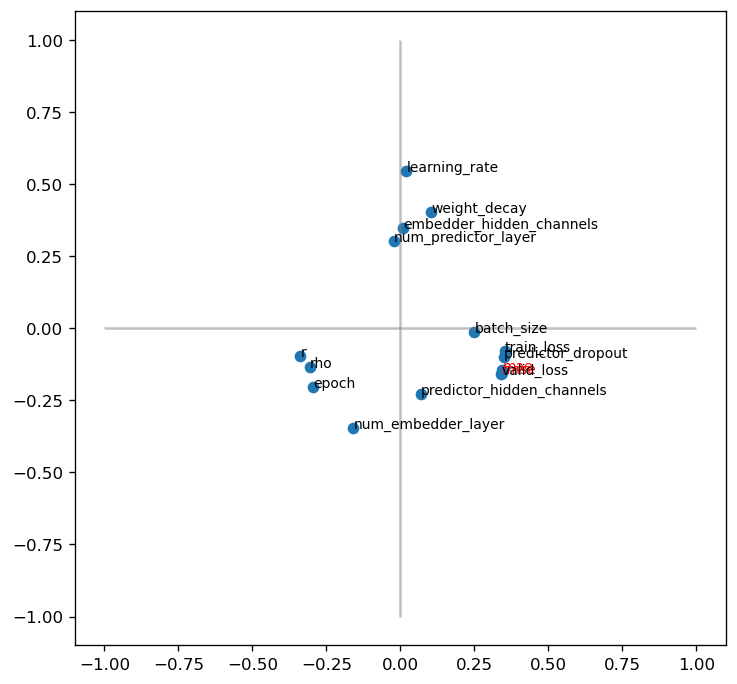

In [15]:
plt.figure(figsize=(7, 7), dpi=120)
plt.hlines(y=0, xmin=-1, xmax=1, colors="grey", alpha=.5)
plt.vlines(x=0, ymin=-1, ymax=1, colors="grey", alpha=.5)
plt.scatter(x=data_pca_loading.PC1, y=data_pca_loading.PC2)
labels = list(data_pca_loading.index)
for i in range(data_pca_loading.shape[0]):
    label = labels[i]
    if label in ["rmse", "mae"]:
        color = "red"
    else:
        color = "black"
    plt.text(
        x=data_pca_loading.PC1[i],
        y=data_pca_loading.PC2[i],
        s=label,
        fontsize="small",
        color=color
    )

In [16]:
std_scaler_X = StandardScaler()
std_scaler_X.fit(pars_df)
X = std_scaler_X.transform(pars_df)
X = pd.DataFrame(X, columns=list(pars_df.columns))

std_scaler_y = StandardScaler()
std_scaler_y.fit(metric_df.loc[:, ["mae"]])
y = std_scaler_y.transform(metric_df.loc[:, ["mae"]])
y = pd.DataFrame(y, columns=["mae"])

In [17]:
learner = LinearRegression(fit_intercept=True, n_jobs=10)
model = learner.fit(X=X, y=y)
y_hat = model.predict(pars_df)
r2 = model.score(X=X, y=y)
coef = pd.DataFrame({
    "coef": model.feature_names_in_,
    "value": model.coef_[0]
})

In [18]:
coef.sort_values(["value"])

,coef,value
7,predictor_dropout,-0.198098
1,learning_rate,-0.184097
2,weight_decay,-0.161325
6,predictor_hidden_channels,-0.063527
0,batch_size,0.064674
5,num_predictor_layer,0.139271
4,embedder_hidden_channels,0.160018
3,num_embedder_layer,0.254876


In [19]:
data_df.head(15)

,batch_size,learning_rate,weight_decay,num_embedder_layer,embedder_hidden_channels,num_predictor_layer,predictor_hidden_channels,predictor_dropout,epoch,mae,r,rho,rmse,train_loss,valid_loss
arm_name,,,,,,,,,,,,,,,
40_0,32,3.33,4.44,5,180,2,686,0.00,279.0,28.023954,0.947616,0.942492,50.729815,28.796612,27.511934
46_0,32,3.40,4.05,5,182,2,544,0.00,300.0,28.265976,0.945403,0.938244,51.722405,28.605191,27.533490
55_0,32,3.41,4.04,5,195,3,655,0.00,293.0,28.513125,0.945995,0.940003,51.710217,27.704489,27.369952
54_0,32,3.36,4.06,5,204,3,534,0.00,227.0,28.612511,0.946347,0.941370,51.289341,28.393368,27.758266
50_0,64,3.37,4.07,5,191,3,594,0.00,258.0,28.799353,0.946791,0.945712,53.303667,28.294118,27.919680
42_0,32,3.42,4.00,5,196,2,557,0.00,265.0,28.905129,0.945838,0.940933,52.027415,28.976220,27.636782
47_0,32,3.48,3.61,5,174,2,550,0.00,300.0,28.919747,0.944111,0.937719,51.766711,29.915527,27.999992
29_0,64,3.22,3.68,5,179,2,561,0.00,268.0,28.956718,0.945128,0.942879,54.543709,30.078056,28.455002
45_0,32,3.61,3.94,5,201,3,501,0.00,260.0,29.054625,0.946091,0.940463,52.064054,28.127824,28.040292


In [20]:
data_df.to_csv("./output.csv")